# Credit Card Fraud Data
### LT8A - Allan Tan, Gavin Cua

Comparing the results of performing the six resampling techniques described in Notebook 3. Measure the accuracy using the Area Under the Precision-Recall Curve.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

# metrics
from imblearn.metrics import sensitivity_score, geometric_mean_score

#resampling methods
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

# pipeline
from imblearn.pipeline import Pipeline

## Prepare Data

In [24]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/Teaching/ML2_MSDS2025PTB/Notebook2_ClassImbalance/'

In [31]:
data_dir='./'
df = pd.read_csv(data_dir + 'credit_card.csv')
df.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.611712,-0.769705,-0.149759,-0.224877,2.028577,-2.019887,0.292491,-0.523020,0.358468,0.070050,...,-0.075208,0.045536,0.380739,0.023440,-2.220686,-0.201146,0.066501,0.221180,1.79,0
1,-0.814682,1.319219,1.329415,0.027273,-0.284871,-0.653985,0.321552,0.435975,-0.704298,-0.600684,...,-0.128619,-0.368565,0.090660,0.401147,-0.261034,0.080621,0.162427,0.059456,1.98,0
2,-0.318193,1.118618,0.969864,-0.127052,0.569563,-0.532484,0.706252,-0.064966,-0.463271,-0.528357,...,-0.305402,-0.774704,-0.123884,-0.495687,-0.018148,0.121679,0.249050,0.092516,0.89,0


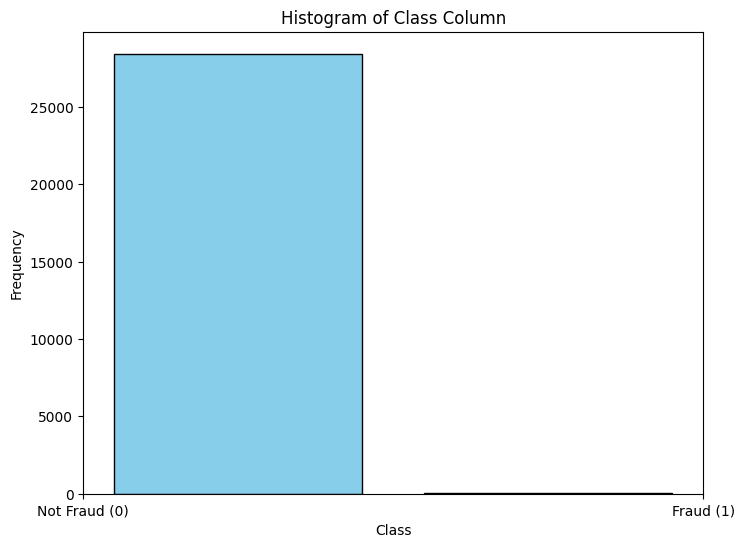

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset (make sure the file path is correct)
df = pd.read_csv(data_dir + 'credit_card.csv')  # Replace with actual file path if necessary

# Create a histogram for the 'Class' column with specific labels for class 0 and 1
plt.figure(figsize=(8,6))
df['Class'].hist(bins=2, color='skyblue', edgecolor='black', rwidth=0.8)
plt.title('Histogram of Class Column')
plt.xlabel('Class')
plt.xticks([0, 1], labels=['Not Fraud (0)', 'Fraud (1)'])  # Adding specific labels for 0 and 1
plt.ylabel('Frequency')
plt.grid(False)
plt.show()


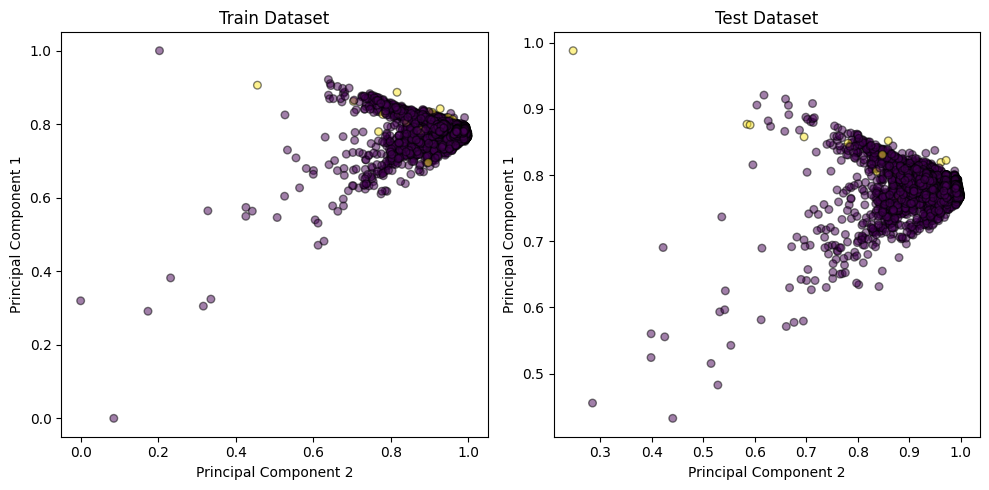

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Split data into train test set
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(df.drop('Class', axis = 1),
                                                    df['Class'],
                                                    test_size = 0.4,
                                                    random_state = 42)

# Scale the dataset on both train and test sets.
# Note that we fit MinMaxScaler on X_train only, not on the entire dataset.
# This prevents data leakage from test set to train set.
scaler = MinMaxScaler()
scaler.fit(X_train1)
X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)


# Function for plotting dataset
def plot_data(X,y,ax,title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(0,0,0,0.5))
    ax.set_ylabel('Principal Component 1')
    ax.set_xlabel('Principal Component 2')
    if title is not None:
        ax.set_title(title)

# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# since the data is already PCA, let's plot the data without PCA

# Plot the Train dataset on the left subplot
plot_data(X_train1, y_train1, ax1, title='Train Dataset')

# Plot the Test dataset on the right subplot
plot_data(X_test1, y_test1, ax2, title='Test Dataset')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

### Note: We are not doing PCA anymore, because as per Kaggle, data is already PCA'ed.

In [99]:
resampling_methods = {
    'No Resampling': None,
    'Random Undersampling': RandomUnderSampler(random_state=143),
    'Random Oversampling': RandomOverSampler(random_state=143),
    'SMOTE': SMOTE(random_state=143),
    'ADASYN': ADASYN(random_state=143),
    'Tomek Links': TomekLinks(),
    'SMOTE + Tomek': SMOTETomek(random_state=143)
}

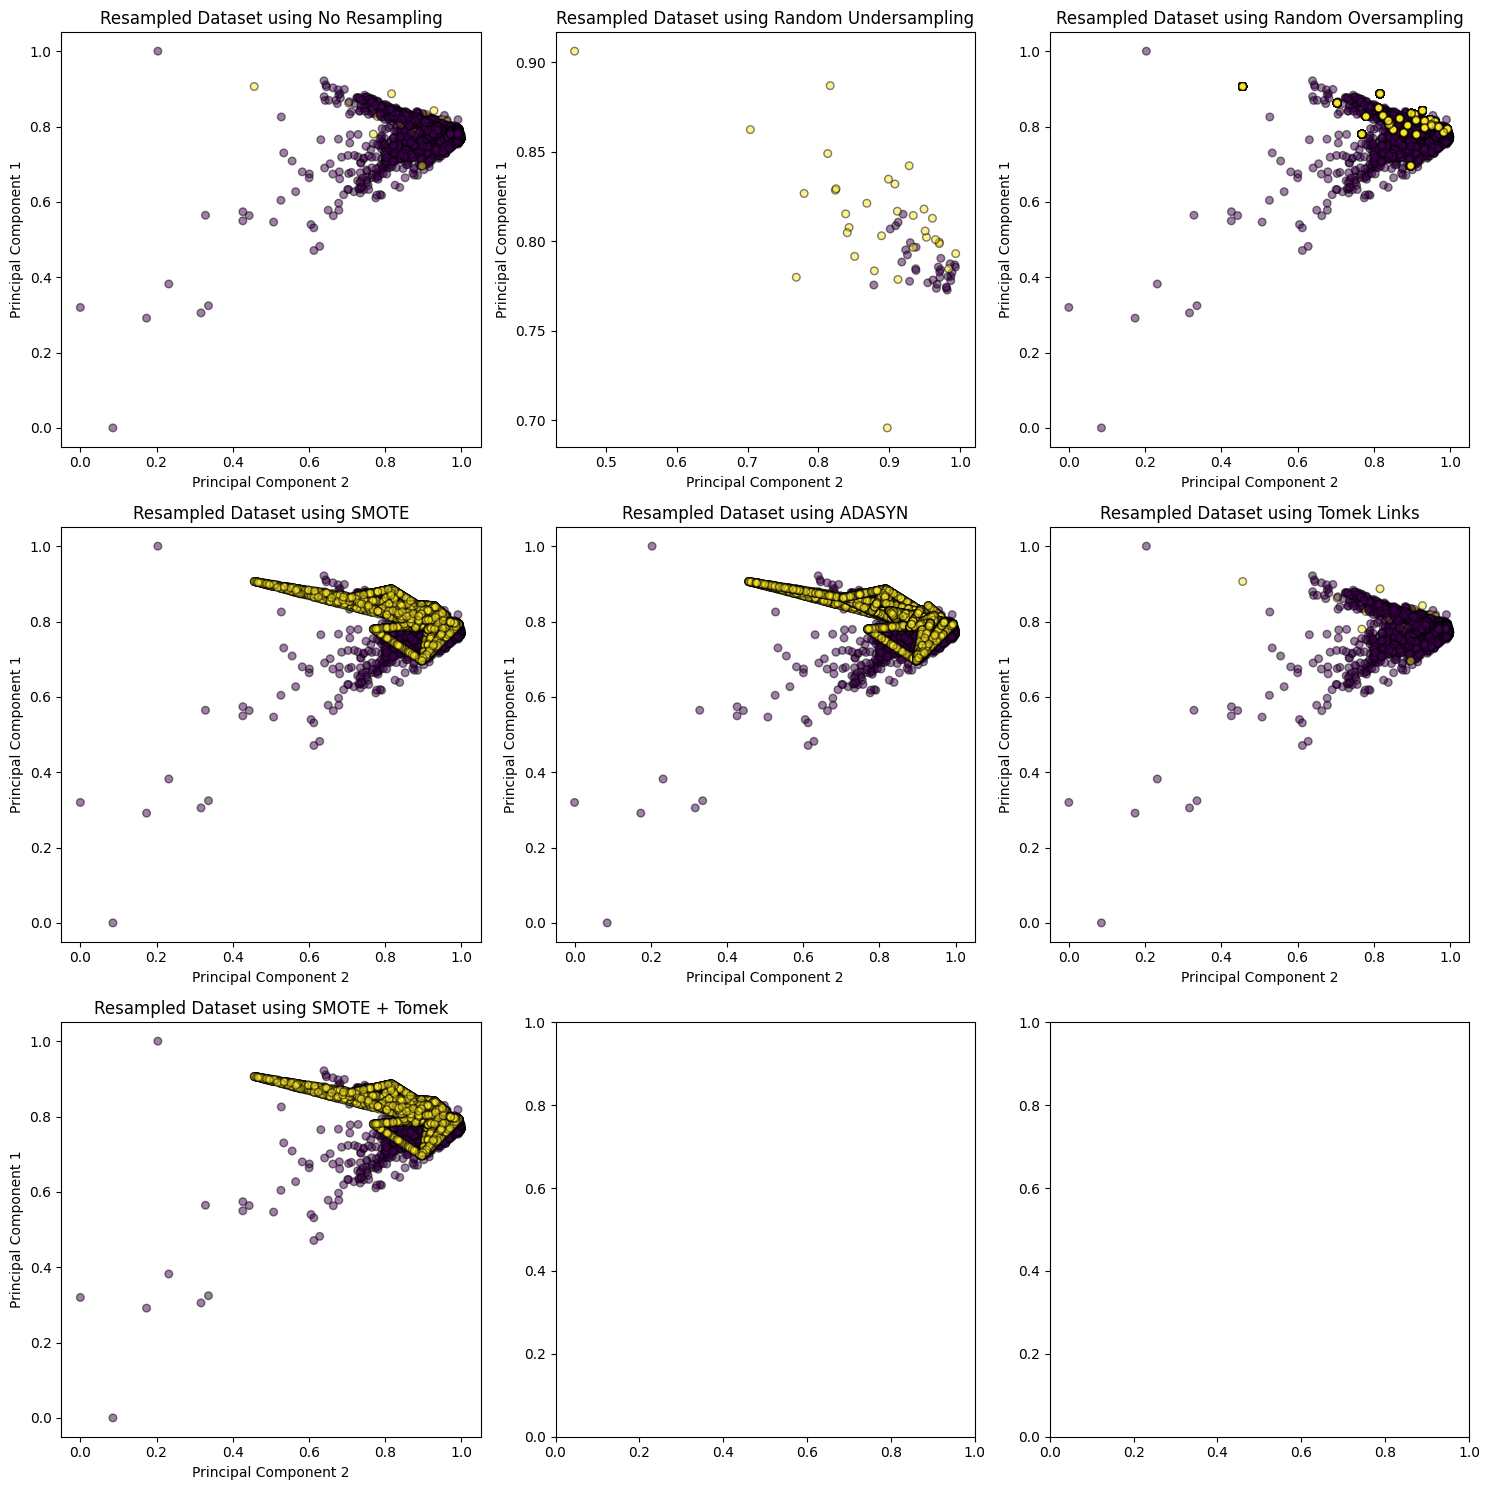

In [100]:
# let's plot the data for each resampling method
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
i = 0
j = 0 
for resampling_name, resampling_method in resampling_methods.items():
    if resampling_method is not None:
      X_train_resampled, y_train_resampled = resampling_method.fit_resample(X_train1, y_train1)
      plot_data(X_train_resampled, y_train_resampled, ax[i,j], title=f'Resampled Dataset using {resampling_name}')
    else:
      plot_data(X_train1, y_train1, ax[i,j], title=f'Resampled Dataset using {resampling_name}')
    j += 1
    if j == 3:
      i += 1
      j = 0
plt.tight_layout()
plt.show()


In [59]:
# Split into trainval and holdout
X, y = df.drop('Class', axis=1), df['Class']

(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y,
                                                                  random_state=143,
                                                                  test_size=0.25,
                                                                  stratify=y)

In [60]:
models_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegressor': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(random_state=143),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)
}

## Let's run different resampling with default hyperparameters

In [65]:
from sklearn.metrics import average_precision_score

skf = StratifiedKFold(n_splits=5)

results = {}

for model_name, model in models_dict.items():
    val_rec_scores = []
    val_gmean_scores = []
    val_prauc_scores = [] 

    for resampling_name, resampling_method in resampling_methods.items():
        start_time = time.time() # for logging run times
        for train_index, val_index in skf.split(X_trainval, y_trainval):
            X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
            y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

            pipeline = Pipeline([(resampling_name, resampling_method),
                                 (model_name, model)])
            pipeline.fit(X_train, y_train)

            train_preds = pipeline.predict(X_train)
            val_preds = pipeline.predict(X_val)
            val_proba = pipeline.predict_proba(X_val)[:, 1]  # Probabilities for positive class

            val_rec_score = sensitivity_score(y_val, val_preds)
            val_gmean_score = geometric_mean_score(y_val, val_preds)
            val_prauc_score = average_precision_score(y_val, val_proba)  # Calculate PR AUC

            val_rec_scores.append(val_rec_score)
            val_gmean_scores.append(val_gmean_score)
            val_prauc_scores.append(val_prauc_score)  # Append PR AUC score
        
            end_time = time.time() # for logging run times
        if resampling_name not in results:
            results[resampling_name] = {}
        results[resampling_name][model_name] = {
            'ave_val_recall': np.mean(val_rec_scores) * 100,
            'ave_val_gmean_score': np.mean(val_gmean_scores) * 100,
            'ave_val_prauc_score': np.mean(val_prauc_scores) * 100,
            'run_time': end_time - start_time
        }
        print(f"Report Generated for {model_name}: {resampling_name} in {results[resampling_name][model_name]['run_time']:.2f} seconds")
        print(f"Average Recall: {results[resampling_name][model_name]['ave_val_recall']:.2f}%")
        print(f"Average G-Mean: {results[resampling_name][model_name]['ave_val_gmean_score']:.2f}%")
        print(f"Average PR AUC: {results[resampling_name][model_name]['ave_val_prauc_score']:.2f}%")
        print("Run Time: ", results[resampling_name][model_name]['run_time'])

results = pd.DataFrame(results).T
display(results)

  0%|          | 0/5 [00:00<?, ?it/s]

Report Generated for KNeighborsClassifier: No Resampling in 4.36 seconds
Average Recall: 41.43%
Average G-Mean: 62.40%
Average PR AUC: 53.25%
Run Time:  4.362786054611206
Report Generated for KNeighborsClassifier: Random Undersampling in 1.76 seconds
Average Recall: 50.71%
Average G-Mean: 68.36%
Average PR AUC: 35.60%
Run Time:  1.757246971130371
Report Generated for KNeighborsClassifier: Random Oversampling in 5.26 seconds
Average Recall: 52.02%
Average G-Mean: 69.88%
Average PR AUC: 37.20%
Run Time:  5.255160808563232
Report Generated for KNeighborsClassifier: SMOTE in 5.13 seconds
Average Recall: 60.62%
Average G-Mean: 75.46%
Average PR AUC: 35.48%
Run Time:  5.129700183868408
Report Generated for KNeighborsClassifier: ADASYN in 5.51 seconds
Average Recall: 65.79%
Average G-Mean: 78.78%
Average PR AUC: 33.93%
Run Time:  5.510010242462158
Report Generated for KNeighborsClassifier: Tomek Links in 4.77 seconds
Average Recall: 61.73%
Average G-Mean: 76.05%
Average PR AUC: 37.27%
Run Tim

 20%|██        | 1/5 [00:36<02:27, 36.93s/it]

Report Generated for KNeighborsClassifier: SMOTE + Tomek in 10.15 seconds
Average Recall: 65.26%
Average G-Mean: 78.36%
Average PR AUC: 36.09%
Run Time:  10.146798133850098
Report Generated for LogisticRegressor: No Resampling in 0.52 seconds
Average Recall: 53.57%
Average G-Mean: 72.54%
Average PR AUC: 68.95%
Run Time:  0.51938796043396
Report Generated for LogisticRegressor: Random Undersampling in 0.07 seconds
Average Recall: 72.50%
Average G-Mean: 82.77%
Average PR AUC: 44.26%
Run Time:  0.07064390182495117
Report Generated for LogisticRegressor: Random Oversampling in 0.88 seconds
Average Recall: 75.48%
Average G-Mean: 84.89%
Average PR AUC: 52.38%
Run Time:  0.8837277889251709
Report Generated for LogisticRegressor: SMOTE in 0.84 seconds
Average Recall: 77.59%
Average G-Mean: 86.43%
Average PR AUC: 56.90%
Run Time:  0.8396422863006592
Report Generated for LogisticRegressor: ADASYN in 0.89 seconds
Average Recall: 79.36%
Average G-Mean: 87.60%
Average PR AUC: 59.68%
Run Time:  0.89

 40%|████      | 2/5 [00:48<01:05, 21.72s/it]

Report Generated for LogisticRegressor: SMOTE + Tomek in 6.19 seconds
Average Recall: 76.33%
Average G-Mean: 85.76%
Average PR AUC: 62.42%
Run Time:  6.185781955718994
Report Generated for RandomForestClassifier: No Resampling in 17.55 seconds
Average Recall: 72.86%
Average G-Mean: 85.17%
Average PR AUC: 84.64%
Run Time:  17.54934310913086
Report Generated for RandomForestClassifier: Random Undersampling in 0.61 seconds
Average Recall: 80.89%
Average G-Mean: 89.16%
Average PR AUC: 79.82%
Run Time:  0.6126539707183838
Report Generated for RandomForestClassifier: Random Oversampling in 14.86 seconds
Average Recall: 75.60%
Average G-Mean: 86.10%
Average PR AUC: 80.96%
Run Time:  14.85880994796753
Report Generated for RandomForestClassifier: SMOTE in 47.13 seconds
Average Recall: 75.00%
Average G-Mean: 85.75%
Average PR AUC: 81.19%
Run Time:  47.12778997421265
Report Generated for RandomForestClassifier: ADASYN in 46.37 seconds
Average Recall: 73.57%
Average G-Mean: 84.77%
Average PR AUC: 

 60%|██████    | 3/5 [04:01<03:20, 100.18s/it]

Report Generated for RandomForestClassifier: SMOTE + Tomek in 49.41 seconds
Average Recall: 73.83%
Average G-Mean: 85.11%
Average PR AUC: 80.86%
Run Time:  49.41287875175476
Report Generated for DecisionTreeClassifier: No Resampling in 1.96 seconds
Average Recall: 65.71%
Average G-Mean: 79.63%
Average PR AUC: 54.60%
Run Time:  1.9589970111846924
Report Generated for DecisionTreeClassifier: Random Undersampling in 0.05 seconds
Average Recall: 76.07%
Average G-Mean: 83.58%
Average PR AUC: 27.97%
Run Time:  0.05362105369567871
Report Generated for DecisionTreeClassifier: Random Oversampling in 1.10 seconds
Average Recall: 71.43%
Average G-Mean: 81.07%
Average PR AUC: 31.57%
Run Time:  1.0956192016601562
Report Generated for DecisionTreeClassifier: SMOTE in 5.50 seconds
Average Recall: 69.20%
Average G-Mean: 80.40%
Average PR AUC: 30.00%
Run Time:  5.504462003707886
Report Generated for DecisionTreeClassifier: ADASYN in 5.35 seconds
Average Recall: 66.71%
Average G-Mean: 78.90%
Average PR 

 80%|████████  | 4/5 [04:27<01:11, 71.02s/it] 

Report Generated for DecisionTreeClassifier: SMOTE + Tomek in 9.51 seconds
Average Recall: 67.40%
Average G-Mean: 79.93%
Average PR AUC: 32.25%
Run Time:  9.512041091918945
Report Generated for GradientBoostingClassifier: No Resampling in 73.19 seconds
Average Recall: 62.14%
Average G-Mean: 78.17%
Average PR AUC: 45.60%
Run Time:  73.18853116035461
Report Generated for GradientBoostingClassifier: Random Undersampling in 0.38 seconds
Average Recall: 72.68%
Average G-Mean: 82.07%
Average PR AUC: 25.60%
Run Time:  0.37751102447509766
Report Generated for GradientBoostingClassifier: Random Oversampling in 86.69 seconds
Average Recall: 73.57%
Average G-Mean: 83.43%
Average PR AUC: 42.36%
Run Time:  86.6867561340332
Report Generated for GradientBoostingClassifier: SMOTE in 149.63 seconds
Average Recall: 74.73%
Average G-Mean: 84.65%
Average PR AUC: 50.33%
Run Time:  149.62959098815918
Report Generated for GradientBoostingClassifier: ADASYN in 150.16 seconds
Average Recall: 73.79%
Average G-M

100%|██████████| 5/5 [16:05<00:00, 193.07s/it]

Report Generated for GradientBoostingClassifier: SMOTE + Tomek in 161.38 seconds
Average Recall: 73.01%
Average G-Mean: 84.10%
Average PR AUC: 57.97%
Run Time:  161.3774631023407


,KNeighborsClassifier,LogisticRegressor,RandomForestClassifier,DecisionTreeClassifier,GradientBoostingClassifier
No Resampling,"{'ave_val_recall': 41.42857142857142, 'ave_val...","{'ave_val_recall': 53.57142857142857, 'ave_val...","{'ave_val_recall': 72.85714285714285, 'ave_val...","{'ave_val_recall': 65.71428571428571, 'ave_val...","{'ave_val_recall': 62.142857142857146, 'ave_va..."
Random Undersampling,"{'ave_val_recall': 50.71428571428571, 'ave_val...","{'ave_val_recall': 72.5, 'ave_val_gmean_score'...","{'ave_val_recall': 80.89285714285715, 'ave_val...","{'ave_val_recall': 76.07142857142858, 'ave_val...","{'ave_val_recall': 72.67857142857143, 'ave_val..."
Random Oversampling,"{'ave_val_recall': 52.02380952380952, 'ave_val...","{'ave_val_recall': 75.47619047619048, 'ave_val...","{'ave_val_recall': 75.5952380952381, 'ave_val_...","{'ave_val_recall': 71.42857142857142, 'ave_val...","{'ave_val_recall': 73.57142857142858, 'ave_val..."
SMOTE,"{'ave_val_recall': 60.62499999999999, 'ave_val...","{'ave_val_recall': 77.58928571428572, 'ave_val...","{'ave_val_recall': 75.00000000000001, 'ave_val...","{'ave_val_recall': 69.19642857142858, 'ave_val...","{'ave_val_recall': 74.73214285714286, 'ave_val..."
ADASYN,"{'ave_val_recall': 65.78571428571429, 'ave_val...","{'ave_val_recall': 79.35714285714286, 'ave_val...","{'ave_val_recall': 73.57142857142858, 'ave_val...","{'ave_val_recall': 66.71428571428572, 'ave_val...","{'ave_val_recall': 73.78571428571429, 'ave_val..."
Tomek Links,"{'ave_val_recall': 61.72619047619048, 'ave_val...","{'ave_val_recall': 75.47619047619048, 'ave_val...","{'ave_val_recall': 73.45238095238096, 'ave_val...","{'ave_val_recall': 68.21428571428572, 'ave_val...","{'ave_val_recall': 72.14285714285715, 'ave_val..."
SMOTE + Tomek,"{'ave_val_recall': 65.25510204081633, 'ave_val...","{'ave_val_recall': 76.32653061224491, 'ave_val...","{'ave_val_recall': 73.8265306122449, 'ave_val_...","{'ave_val_recall': 67.39795918367348, 'ave_val...","{'ave_val_recall': 73.01020408163265, 'ave_val..."


No Resampling : {'model': 'RandomForestClassifier', 'pr_score': 84.63897241736326}
Random Undersampling : {'model': 'RandomForestClassifier', 'pr_score': 79.81711210900879}
Random Oversampling : {'model': 'RandomForestClassifier', 'pr_score': 80.96132273891357}
SMOTE : {'model': 'RandomForestClassifier', 'pr_score': 81.19401938361464}
ADASYN : {'model': 'RandomForestClassifier', 'pr_score': 81.04110978530628}
Tomek Links : {'model': 'RandomForestClassifier', 'pr_score': 80.87515110421333}
SMOTE + Tomek : {'model': 'RandomForestClassifier', 'pr_score': 80.85893313995666}


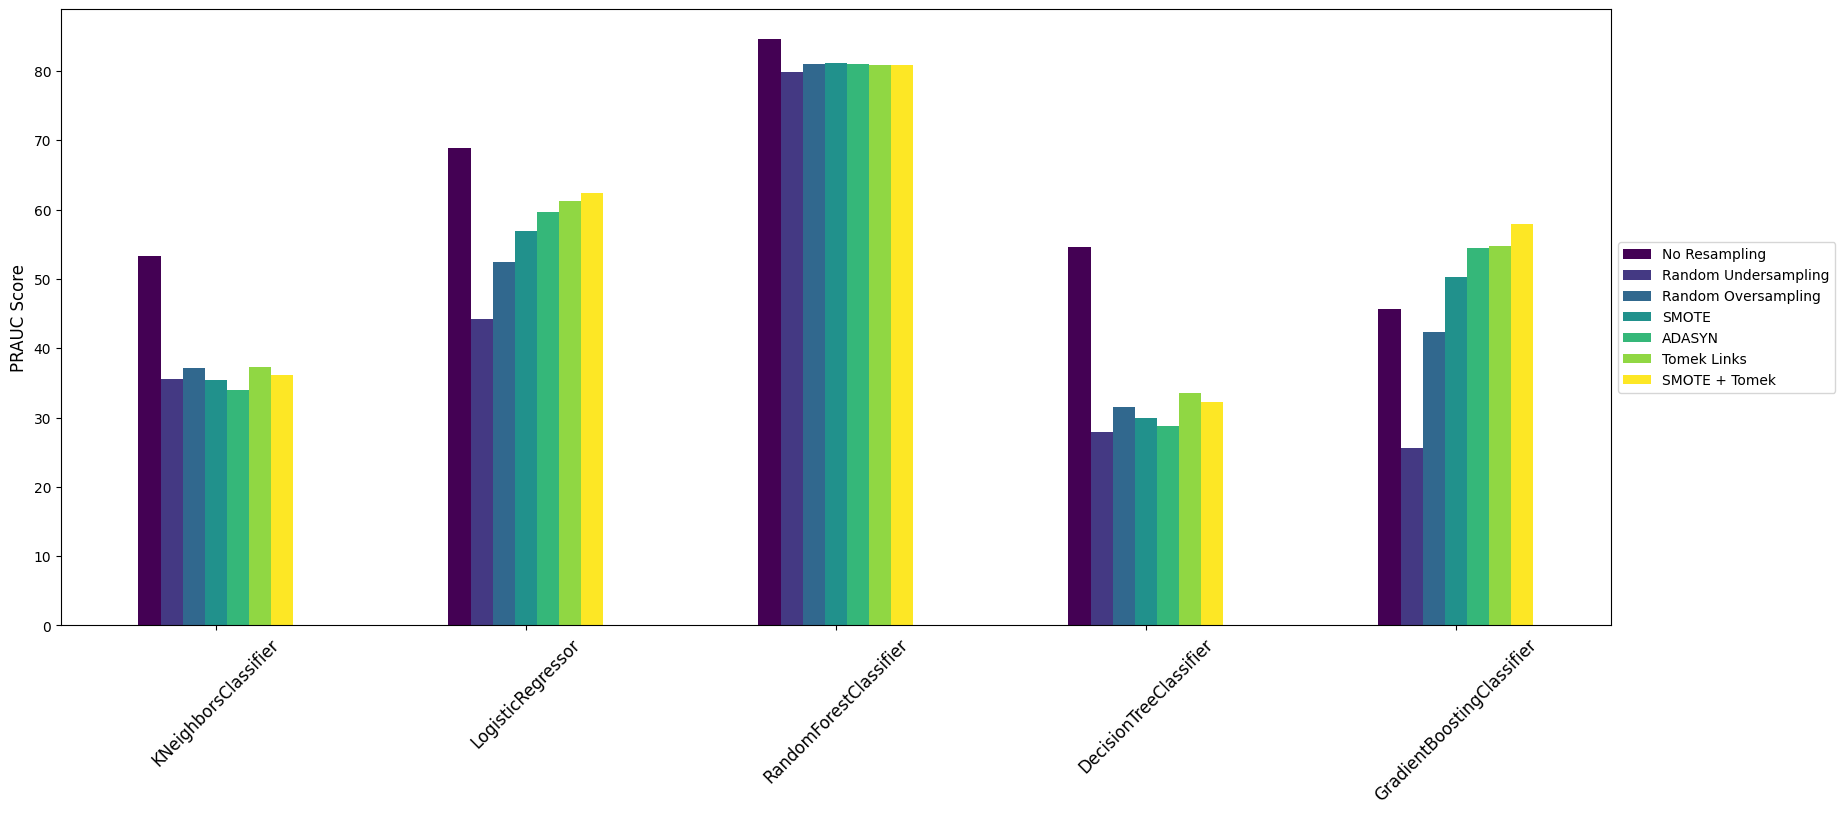

In [90]:
plot_res = pd.DataFrame(index=models_dict.keys())
# loop the results and store the ave_val_prauc_score
best_results = {}
for resampling_name, resampling_method in resampling_methods.items():
    for model_name, model_method in models_dict.items():
        # print(model_name, ':', resampling_name, ':', results[model_name][resampling_name]['ave_val_prauc_score'])
        plot_res.loc[model_name, resampling_name] = results[model_name][resampling_name]['ave_val_prauc_score']
        if resampling_name not in best_results:
            best_results[resampling_name] = {'model': model_name, 'prauc_score': results[model_name][resampling_name]['ave_val_prauc_score']}
        elif results[model_name][resampling_name]['ave_val_prauc_score'] > best_results[resampling_name]['prauc_score']:
            best_results[resampling_name] = {'model': model_name, 'prauc_score': results[model_name][resampling_name]['ave_val_prauc_score']}

for best in best_results:
    print(best, ':', best_results[best])

_, ax = plt.subplots(figsize=(20, 8))
plot_res.plot.bar(ax=ax, cmap='viridis')
ax.set_ylabel('PRAUC Score', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.show()



It appears that RandomForest with No resampling performs best with 84.63% PRAUC. We should try other alternatives...

### Now, let's try to optimize and find the best hyperparameters using RandomForest and GradientBoosting


In [92]:
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from scipy.stats import randint, uniform

# Define parameter distributions for RandomForest
rf_param_dist = {
    'model__n_estimators': randint(10, 100),
    'model__max_depth': randint(5, 15),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 10),
    'model__max_features': ['auto', 'sqrt', 'log2']
}

# Define parameter distributions for GradientBoosting
gb_param_dist = {
    'model__n_estimators': randint(10, 100),
    'model__learning_rate': uniform(0.01, 0.3),
    'model__max_depth': randint(3, 10),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 10),
    'model__subsample': uniform(0.6, 0.4)
}

# Function to perform hyperparameter tuning
def tune_model(X, y, model, param_dist, resampler=None, n_iter=10, cv=5):
    if resampler:
        pipeline = Pipeline([
            ('resampler', resampler),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([('model', model)])
    
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, n_iter=n_iter, 
        cv=cv, scoring='average_precision', n_jobs=-1, random_state=143
    )
    random_search.fit(X, y)
    return random_search.best_estimator_, random_search.best_score_

# Perform tuning for both models with all resampling methods
results = {}

for model_name, model, param_dist in tqdm([
    ('RandomForest', RandomForestClassifier(random_state=143), rf_param_dist),
    ('GradientBoosting', GradientBoostingClassifier(random_state=143), gb_param_dist)
], desc="Models"):
    model_results = {}
    for resampler_name, resampler in tqdm(resampling_methods.items(), desc=f"Resampling methods for {model_name}", leave=False):
        print(f"Tuning {model_name} with {resampler_name}...")
        best_model, best_score = tune_model(X_trainval, y_trainval, model, param_dist, resampler)
        model_results[resampler_name] = {
            'best_model': best_model,
            'best_score': best_score
        }
        print(f"Best score: {best_score}")
    results[model_name] = model_results

# Display results
for model_name, model_results in results.items():
    print(f"\nBest results for {model_name}:")
    for resampler_name, result in model_results.items():
        print(f"  {resampler_name}: PR AUC = {result['best_score']:.4f}")
        print(f"    Best parameters: {result['best_model'].named_steps['model'].get_params()}")

Models:   0%|          | 0/2 [00:00<?, ?it/s]

Tuning RandomForest with No Resampling...


Best score: 0.8281300843779775
Tuning RandomForest with Random Undersampling...


Best score: 0.7186146151578017
Tuning RandomForest with Random Oversampling...


Best score: 0.8221462792476034
Tuning RandomForest with SMOTE...


Best score: 0.8133554690151481
Tuning RandomForest with ADASYN...


Best score: 0.7994690826686827
Tuning RandomForest with Tomek Links...


Best score: 0.778954605697721
Tuning RandomForest with SMOTE + Tomek...


Models:  50%|█████     | 1/2 [04:07<04:07, 247.69s/it]

Best score: 0.8158234495265768


Tuning GradientBoosting with No Resampling...


Best score: 0.7415103243721297
Tuning GradientBoosting with Random Undersampling...


Best score: 0.7121236859047624
Tuning GradientBoosting with Random Oversampling...


Best score: 0.8618271090070703
Tuning GradientBoosting with SMOTE...


Best score: 0.7902433725447062
Tuning GradientBoosting with ADASYN...


Best score: 0.7886934936248775
Tuning GradientBoosting with Tomek Links...


Best score: 0.6963957192405027
Tuning GradientBoosting with SMOTE + Tomek...


Models: 100%|██████████| 2/2 [25:50<00:00, 775.25s/it]

Best score: 0.8031124593642321

Best results for RandomForest:
  No Resampling: PR AUC = 0.8281
    Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 28, 'n_jobs': None, 'oob_score': False, 'random_state': 143, 'verbose': 0, 'warm_start': False}
  Random Undersampling: PR AUC = 0.7186
    Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 28, 'n_jobs': None, 'oob_score': False, 'random_state': 143, 'verbose': 0, 'warm_start': False}
  Random Oversampling: PR AUC = 0.8221
    Bes

With hyper-parameter tuning, we were able to get slightly better performance using Gradient Descent
with PR AUC = 0.8618 with the following settings {'learning_rate': 0.23132648849519227, 'loss': 'log_loss', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 68, 'random_state': 143, 'subsample': 0.7695752062568093, 'tol': 0.0001, 'validation_fraction': 0.1, }


### How about we change hyper parameters of the resampling methods?

In [104]:
random_oversampler_param_dist = {
    'resampler__sampling_strategy': uniform(0.1, 0.9)
}

random_undersampler_param_dist = {
    'resampler__sampling_strategy': uniform(0.1, 0.9)
}

smote_param_dist = {
    'resampler__k_neighbors': randint(2, 10),
}

adasyn_param_dist = {
    'resampler__n_neighbors': randint(2, 10),
}

tomek_param_dist = {
    'resampler__n_jobs': [-1]
}

smote_tomek_param_dist = {
    'resampler__sampling_strategy': uniform(0.1, 0.9)
}

resampling_param_dist = {
    'Random Oversampling': random_oversampler_param_dist,
    'Random Undersampling': random_undersampler_param_dist,
    'SMOTE': smote_param_dist,
    'ADASYN': adasyn_param_dist,
    'Tomek Links': tomek_param_dist,
    'SMOTE + Tomek': smote_tomek_param_dist
}

# Perform tuning for random forest with all resampling methods
results = {}

for resampler_name, param_dist in resampling_param_dist.items():
    print(f"Tuning {resampler_name}...")
    best_model, best_score = tune_model(X_trainval, y_trainval, RandomForestClassifier(random_state=143), param_dist, resampler=resampling_methods[resampler_name])
    results[resampler_name] = {
        'best_model': best_model,
        'best_score': best_score
    }
    print(f"Best score: {best_score}")

# Display results
for resampler_name, result in results.items():
    print(f"  {resampler_name}: PR AUC = {result['best_score']:.4f}")
    print(f"    Best parameters: {result['best_model'].named_steps['model'].get_params()}")


Tuning Random Oversampling...
Best score: 0.840165680187779
Tuning Random Undersampling...
Best score: 0.7284408426829303
Tuning SMOTE...
Best score: 0.827547738988492
Tuning ADASYN...
Best score: 0.8096769003901574
Tuning Tomek Links...
Best score: 0.8004535769874854
Tuning SMOTE + Tomek...
Best score: 0.8383953718861866
  Random Oversampling: PR AUC = 0.8402
    Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 143, 'verbose': 0, 'warm_start': False}
  Random Undersampling: PR AUC = 0.7284
    Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': 

### Let's use the best hyperparameter for each resampling method, and find the best hyper-parameter for random forest.

In [107]:
# get the best resampling method for each model
best_resampling_methods = {}
for resampling_name, resampling_method in resampling_methods.items():
    best_model, best_score = tune_model(X_trainval, y_trainval, 
                                        RandomForestClassifier(random_state=143), 
                                        rf_param_dist, resampler=resampling_method)
    best_resampling_methods[resampling_name] = {'best_model': best_model, 'best_score': best_score}

# print the
# now, let's tune the random forest with the best resampling method
# for model_name, model, param_dist in tqdm([
#     ('RandomForest', RandomForestClassifier(random_state=143), rf_param_dist),
#     ('GradientBoosting', GradientBoostingClassifier(random_state=143), gb_param_dist)
# ], desc="Models"):
#     model_results = {}
#     for resampler_name, resampler in tqdm(resampling_methods.items(), desc=f"Resampling methods for {model_name}", leave=False):
#         print(f"Tuning {model_name} with {resampler_name}...")
#         best_model, best_score = tune_model(X_trainval, y_trainval, model, param_dist, resampler)
#         model_results[resampler_name] = {
#             'best_model': best_model,
#             'best_score': best_score
#         }
#         print(f"Best score: {best_score}")
#     results[model_name] = model_results

In [108]:
print(best_resampling_methods)

{'No Resampling': {'best_model': Pipeline(steps=[('model',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        min_samples_leaf=3, min_samples_split=5,
                                        n_estimators=28, random_state=143))]), 'best_score': 0.8281300843779775}, 'Random Undersampling': {'best_model': Pipeline(steps=[('resampler', RandomUnderSampler(random_state=143)),
                ('model',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        min_samples_leaf=3, min_samples_split=5,
                                        n_estimators=28, random_state=143))]), 'best_score': 0.7186146151578017}, 'Random Oversampling': {'best_model': Pipeline(steps=[('resampler', RandomOverSampler(random_state=143)),
                ('model',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        min_samples_split=7, n

## Insights:

* PR-AUC measures performance better when handling imbalance dataset because it emphasizes performance of the minority class. 
* The PR AUC score doesn’t incorporate True Negatives and therefore is less likely to exaggerate model performance for unbalanced datasets.
* The No Resampling is performing well across multiple models. This is likely because the data is already PCA'ed which means the most important features have already been captured in the data. 
* Random Forest and Gradient Boosting are the best performers. When tuning hyper-parameters, GB achieved 86% PRAUC, while Random Forest achieved 84%.
* Tuning hyper parameters for different resampling method improved the performance across all models. 